# Deep Learning with PyTorch : Build a Generative Adversarial Network

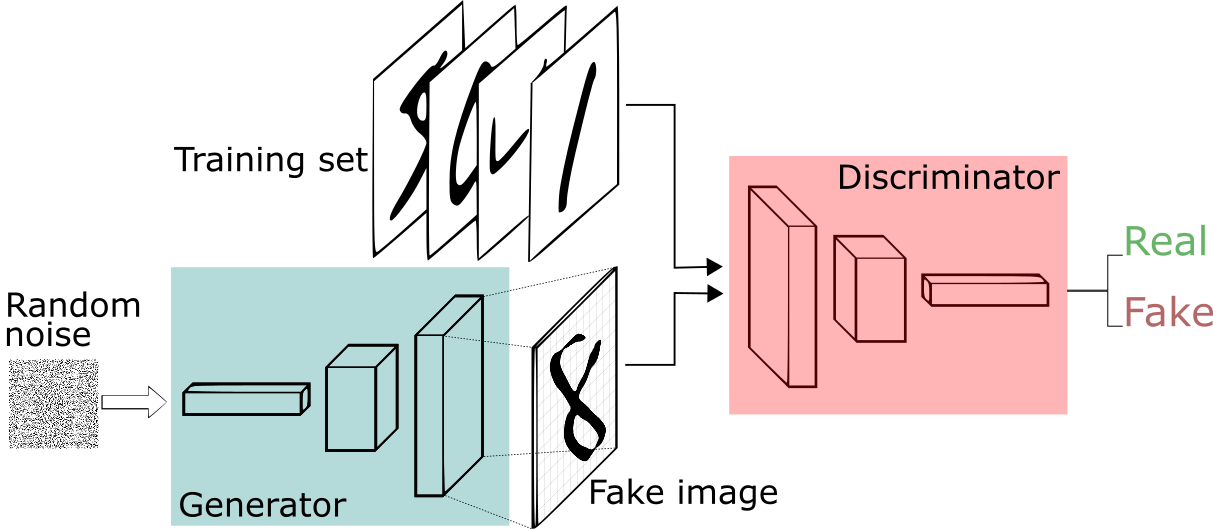

In [ ]:
import torch
torch.manual_seed(42)
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# Configurations

In [ ]:
device = 'cuda' #image = image.to(device) to transfer image to gpu

batch_size = 128 #trainloder , training loop
noise_dim = 64 #generator model

#optimizer parameters
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.99

#training Variables
epochs = 20

# Load MNIST Dataset

In [ ]:
from torchvision import datasets, transforms as T

In [ ]:
train_augs = T.Compose([
    T.RandomRotation((-20, +20)),
    T.ToTensor() #This converts the numpy or pl images into torch tensor
                # (height, width, channel) -> (c,h,w)
])

In [ ]:
trainset = datasets.MNIST('MNIST/', download = True, train = True, transform = train_augs)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]


Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 482kB/s]


Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.44MB/s]


Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.07MB/s]

Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



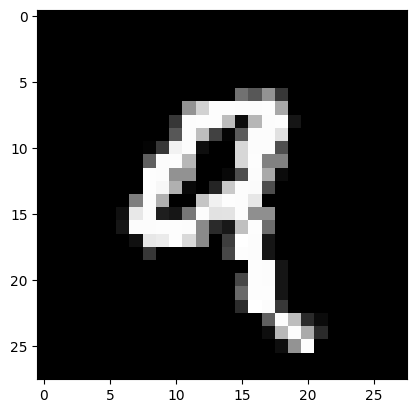

In [ ]:
image, lable = trainset[4]
plt.imshow(image.squeeze(), cmap = 'gray')

In [ ]:
print("total images preset in trainset are: ", len(trainset))

total images preset in trainset are:  60000


# Load Dataset Into Batches

In [ ]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [ ]:
trainloader = DataLoader(trainset, batch_size = batch_size, shuffle = True)

In [ ]:
print(" Total number of batches in trainloader: ", len(trainloader))

 Total number of batches in trainloader:  469


In [ ]:
dataiter = iter(trainloader)
images, _ = next(dataiter)  # Use next(dataiter) instead of dataiter.next()
print(images.shape)

torch.Size([128, 1, 28, 28])


In [ ]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

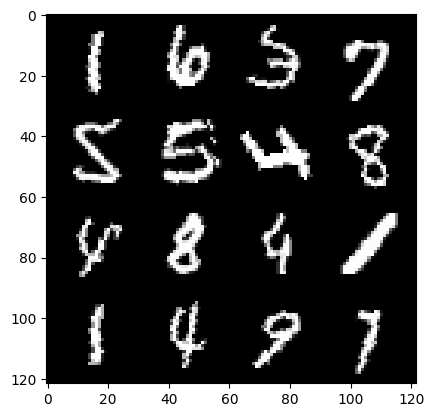

In [ ]:
show_tensor_images(images, num_images =16)

# Create Discriminator Network

In [ ]:
#In case if torch summary is not installed

!pip install torchsummary

In [ ]:
from torch import nn
from torchsummary import summary

In [ ]:
'''

Network : Discriminator

input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''

In [ ]:
def get_disc_block(in_channels, out_channels, kernel_size, stride):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2)
    )

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.block_1 = get_disc_block(1, 16, (3,3), 2)
        self.block_2 = get_disc_block(16, 32, (5,5), 2)
        self.block_3 = get_disc_block(32, 64, (5,5), 2)

        self.flatten = nn.Flatten()
        self.linear = nn.Linear(in_features = 64, out_features = 1)

    def forward(self, x):
        x = x.to(device)
        x1 = self.block_1(x)
        x2 = self.block_2(x1)
        x3 = self.block_3(x2)

        x4 = self.flatten(x3)
        x5 = self.linear(x4)

        return x5

In [ ]:
D = Discriminator()
D.to(device)

summary(D, input_size= (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Create Generator Network

In [ ]:
'''

Network : Generator

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

In [ ]:
def get_gen_block(in_channels, out_channels, kernel_size, stride, final_block = False):
  if final_block == True:
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
        nn.Tanh()
    )
  return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

In [ ]:
class Generator(nn.Module):
    def __init__(self, noise_dim):
        super(Generator, self).__init__()

        self.noise_dim = noise_dim

        self.block_1 = get_gen_block(noise_dim, 256, (3,3), 2)
        self.block_2 = get_gen_block(256, 128, (4,4), 1)
        self.block_3 = get_gen_block(128, 64, (3,3), 2)

        self.block_4 = get_gen_block(64, 1, (4,4), 2, final_block = True)

    def forward(self, r_noise_vec):

      #(bs, noise_dim) -> (bs, noise_dim, 1,1)
      x= r_noise_vec.view(-1, self.noise_dim, 1, 1)

      x1 = self.block_1(x)
      x2 = self.block_2(x1)
      x3 = self.block_3(x2)
      x4 = self.block_4(x3)

      return x4

In [ ]:
G = Generator(noise_dim)
G.to(device)

summary(G, input_size = (1,noise_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [ ]:
# Replace Random initialized weights to Normal weights

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [ ]:
D.apply(weights_init)
G.apply(weights_init)

Generator(
  (block_1): Sequential(
    (0): ConvTranspose2d(64, 256, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block_2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block_3): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block_4): Sequential(
    (0): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2))
    (1): Tanh()
  )
)

# Create Loss Function and Load Optimizer

In [ ]:
def real_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.ones_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss

def fake_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.zeros_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss

In [ ]:
D_opt = torch.optim.Adam(D.parameters(), lr = lr, betas = (beta_1, beta_2))
G_opt = torch.optim.Adam(G.parameters(), lr = lr, betas = (beta_1, beta_2))

# Training Loop

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 1 | disc_loss: 0.5975260790477175 | gen_loss: 0.8308859353126493


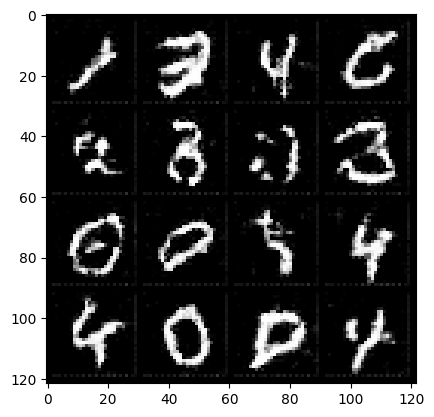

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 2 | disc_loss: 0.5945020074020825 | gen_loss: 0.8460645096134275


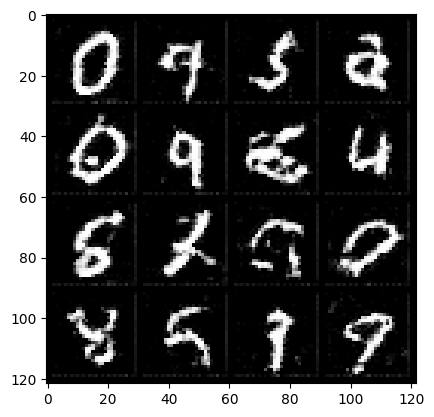

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 3 | disc_loss: 0.5971108361093729 | gen_loss: 0.8564175521132789


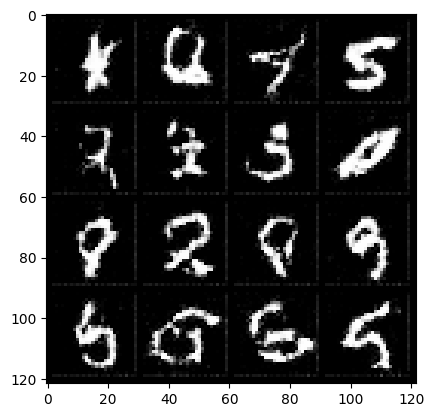

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 4 | disc_loss: 0.6062034826034676 | gen_loss: 0.8542309732579473


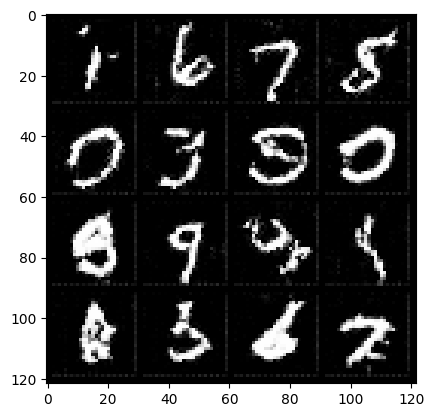

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 5 | disc_loss: 0.6127562841881059 | gen_loss: 0.8536843990466234


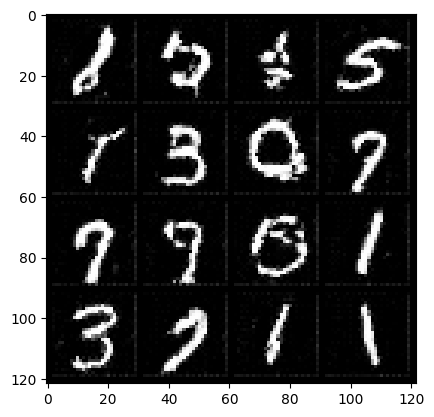

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 6 | disc_loss: 0.6198147283688283 | gen_loss: 0.8474867530723116


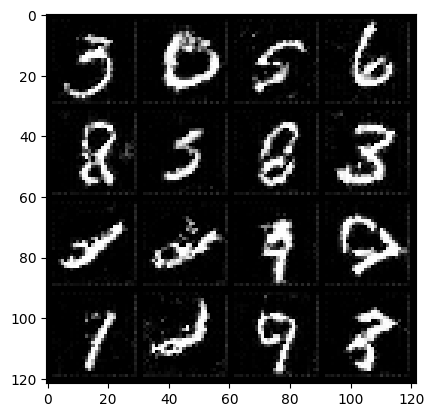

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 7 | disc_loss: 0.6232091516319876 | gen_loss: 0.8427883605204666


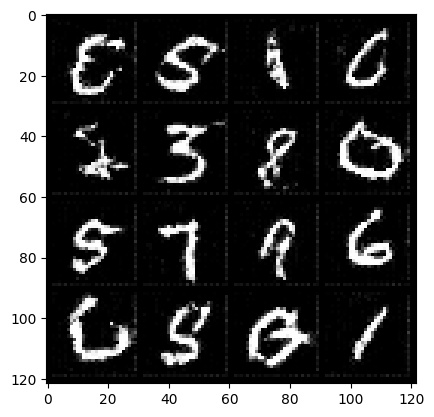

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 8 | disc_loss: 0.6295905430942202 | gen_loss: 0.8369486647119908


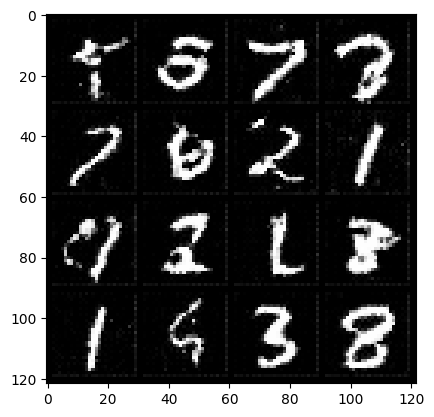

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 9 | disc_loss: 0.6320264497037127 | gen_loss: 0.8316519048168207


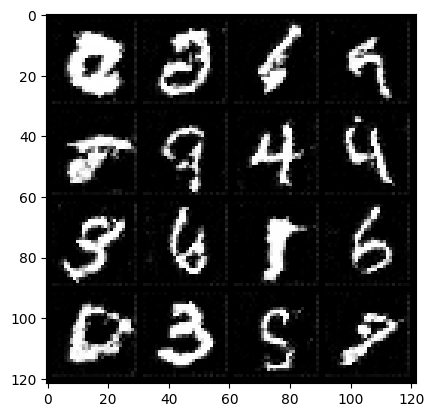

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 10 | disc_loss: 0.6350398962177447 | gen_loss: 0.8287731669604905


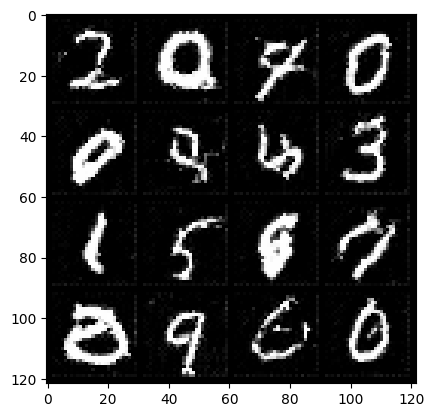

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 11 | disc_loss: 0.6378295875307339 | gen_loss: 0.824800667732255


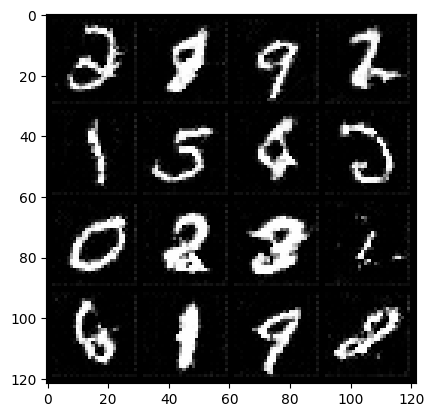

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 12 | disc_loss: 0.6383284304950283 | gen_loss: 0.820668694688313


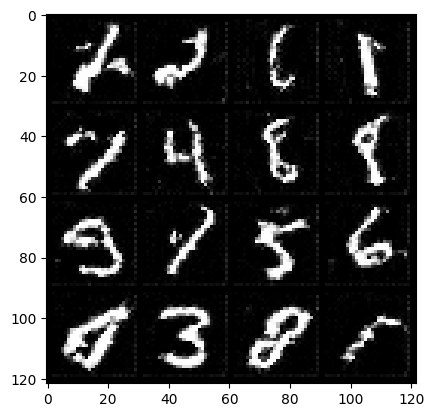

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 13 | disc_loss: 0.6400418622153146 | gen_loss: 0.8215829630904614


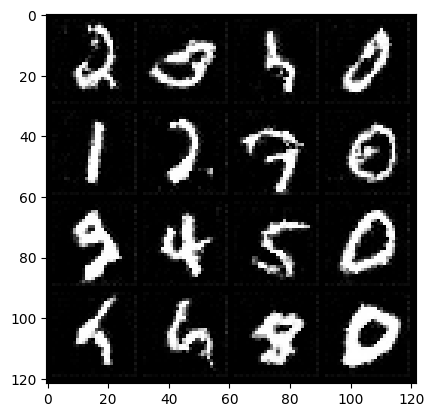

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 14 | disc_loss: 0.6422697109962577 | gen_loss: 0.8185116369078662


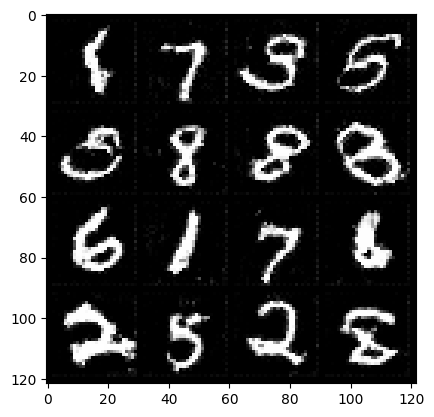

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 15 | disc_loss: 0.6416482467895378 | gen_loss: 0.8211809973726903


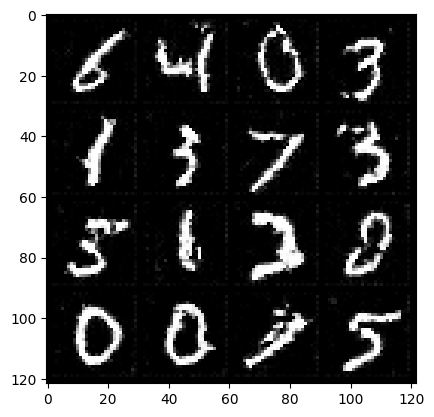

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 16 | disc_loss: 0.641913056500685 | gen_loss: 0.8187292754523027


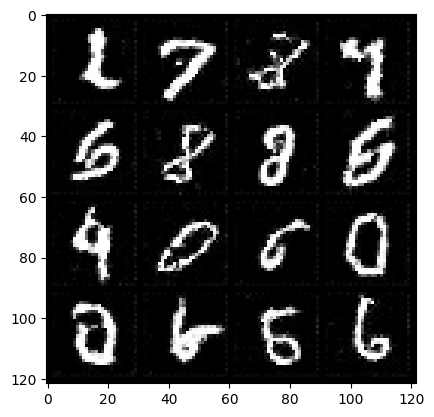

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 17 | disc_loss: 0.6407693747772591 | gen_loss: 0.8193285542764643


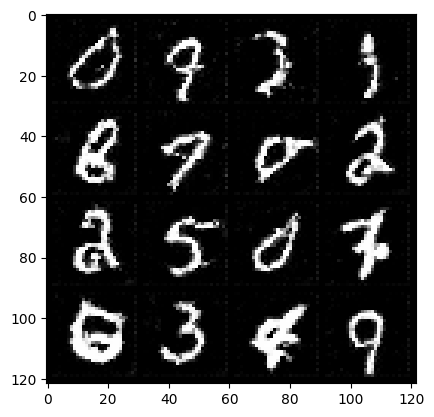

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 18 | disc_loss: 0.6406359612814653 | gen_loss: 0.823590561270968


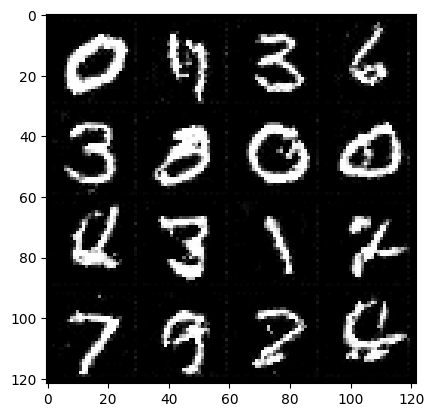

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 19 | disc_loss: 0.639569133456582 | gen_loss: 0.8255010955115117


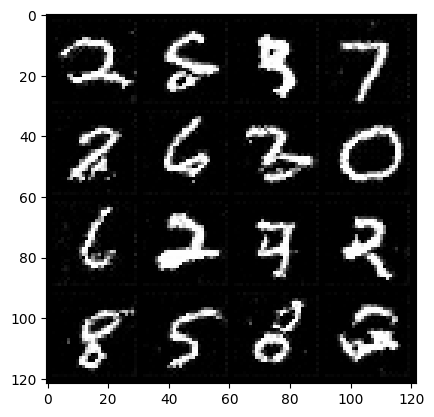

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 20 | disc_loss: 0.6387860349246434 | gen_loss: 0.8306200612328454


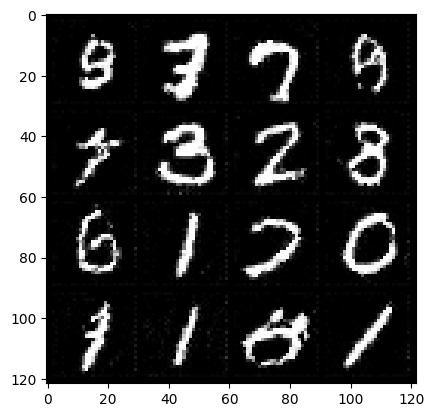

In [ ]:
for i in range(epochs):

  total_d_loss = 0
  total_g_loss = 0

  for real_images, _ in tqdm(trainloader):
    real_images = real_images.to(device)
    batch_size = real_images.shape[0]

    noise = torch.randn(batch_size, noise_dim, device = device)

    #find loss and update weights for D
    D_opt.zero_grad()

    fake_images = G(noise)
    disc_fake_pred = D(fake_images)
    disc_fake_loss = fake_loss(disc_fake_pred)

    disc_fake_pred = D(real_images)
    disc_real_loss = real_loss(disc_fake_pred)

    disc_loss = (disc_fake_loss + disc_real_loss)/2

    total_d_loss += disc_loss.item()

    disc_loss = disc_loss.to(device)
    disc_loss.backward()
    D_opt.step()

    #find loss and update weights for G
    G_opt.zero_grad()
    noise = torch.randn(batch_size, noise_dim, device = device)

    fake_images = G(noise)
    disc_fake_pred = D(fake_images)
    gen_loss = real_loss(disc_fake_pred)

    total_g_loss += gen_loss.item()
    gen_loss = gen_loss.to(device)
    gen_loss.backward()
    G_opt.step()

  avg_d_loss = total_d_loss / len(trainloader)
  avg_g_loss = total_g_loss /  len(trainloader)

  print("Epoch: {} | disc_loss: {} | gen_loss: {}".format(i+1, avg_d_loss, avg_g_loss))
  show_tensor_images(fake_images)


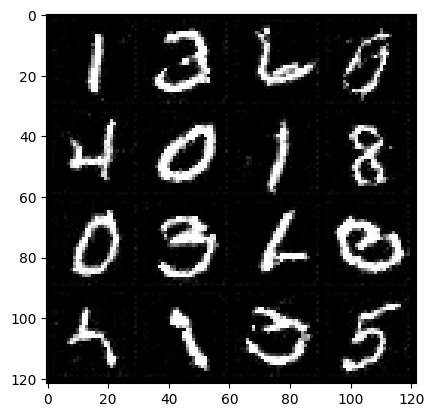

In [ ]:
# Run after training is completed.
# Now you can use Generator Network to generate handwritten images

noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = G(noise)

show_tensor_images(generated_image)